Moneyball was a good movie, wasn't it? <br>
https://www.youtube.com/watch?v=Tzin1DgexlE

In [1]:
import statsapi
import re
import os
import ast
import json
import numpy as np
from tqdm.keras import TqdmCallback


import tensorflow as tf
has_gpu = tf.test.gpu_device_name() != ''

### Collect Data

In [4]:
# get raw game info and filter out non regular season games
games_raw = statsapi.schedule(start_date='03/29/2018',end_date='10/28/2018')
games_raw = [game for game in games_raw if game['game_type'] == 'R']

In [5]:
# parse through the raw games data
games = [] # list of filtered game data
team_ids = set([]) # set of unique team ids
for raw_game in games_raw:    # update team_ids with the teams playing
    team_ids.add(home_id := str(raw_game['home_id']))
    team_ids.add(away_id := str(raw_game['away_id']))
    
    # filter game data
    winner = 1 if raw_game['home_score'] > raw_game['away_score'] else (0 if raw_game['home_score'] == raw_game['away_score'] else -1)
    games.append({'winner': winner, 'home_id': home_id, 'away_id': away_id})


In [6]:
# create set of all player names
roster_regex = r'#\d+\s+(?:\w|\d)+\s+(.*)'
team_players = {}
player_names = set([])
for team_id in team_ids:
    roster = statsapi.roster(team_id, season='2018')
    roster_names = re.findall(roster_regex, roster)
    team_players[team_id] = roster_names
    player_names.update(roster_names)

In [9]:
# create set of all player names and ids
player_ids = {}
ping_count = 0
for player_name in player_names:
    print("Pings: %d" % ping_count, end='\r')
    ping_count += 1

    player_id = statsapi.lookup_player(player_name, season=2018)[0]['id']
    player_ids[player_name] = str(player_id)

In [10]:
# get stats for all players
data_regex = r'(\w+): (\d*.?\d+)'
player_data = {}
broken_players = []
ping_count = 0
NUM_PLAYERS
for _, player_id in player_ids.items():
    print("Pings: %d" % ping_count, end='\r')
    ping_count += 1
    
    try:
        datalines = statsapi.player_stats(player_id, group='hitting', type='career').splitlines()
    except: # TODO what do we do about the missing player data?
        broken_players.append(player_id)
        continue

    data = [re.findall(data_regex, line)[0] for line in datalines if re.findall(data_regex, line)]
    player_data[player_id] = {}
    for data_key, data in data:
        player_data[player_id][data_key] = float(data)

### Dump Data

In [36]:
# print out games, team_ids, players, and player_data to file to save API calls
if not os.path.isdir('raw_data'):
   os.mkdir('raw_data')

with open('raw_data/games.json', 'w') as file:
   file.writelines([str(game) + '\n' for game in games])
   
with open('raw_data/team_players.json', 'w') as file:
    json.dump(team_players, file, indent=4)
   
with open('raw_data/player_ids.json', 'w') as file:
    json.dump(player_ids, file, indent=4)

with open('raw_data/player_data.json', 'w') as file:
    json.dump(player_data, file, indent=4)

### Read Data

In [2]:
# read in games, team_ids, and players from cached files
with open('raw_data/games.json', 'r') as file:
    games = [ast.literal_eval(line) for line in file]
   
with open('raw_data/team_players.json', 'r') as file:
    team_players = json.load(file)
   
with open('raw_data/player_ids.json', 'r') as file:
    player_ids = json.load(file)

with open('raw_data/player_data.json', 'r') as file:
    player_data = json.load(file)

### Create Dataset

In [33]:
# nomralize the data
collected_stats = {}
for stat_key in player_data[list(player_data.keys())[0]]:
    collected_stats[stat_key] = []

for stats in player_data.values():
    for stat_key, stat in stats.items():
        collected_stats[stat_key].append(stat)

stat_means = {}
stat_stds = {}
for stat_key, stats in collected_stats.items():
    stat_means[stat_key] = np.mean(stats)
    stat_stds[stat_key] = np.std(stats)

for player in player_data:
    for stat_key, stat in player_data[player].items():
        player_data[player][stat_key] -= stat_means[stat_key]
        player_data[player][stat_key] /= stat_stds[stat_key]

In [4]:
player_data[player].keys()

dict_keys(['gamesPlayed', 'groundOuts', 'airOuts', 'runs', 'doubles', 'triples', 'homeRuns', 'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch', 'avg', 'atBats', 'obp', 'slg', 'ops', 'caughtStealing', 'stolenBases', 'stolenBasePercentage', 'groundIntoDoublePlay', 'numberOfPitches', 'plateAppearances', 'totalBases', 'rbi', 'leftOnBase', 'sacBunts', 'sacFlies', 'babip', 'groundOutsToAirouts', 'catchersInterference', 'atBatsPerHomeRun'])

In [47]:
# create a data set for the model
X = []
Y = []
feature_fields = ['gamesPlayed', 'runs', 'doubles', 'triples', 'homeRuns', 'strikeOuts', 'avg', 'obp', 'slg', 'ops']
NUM_PLAYERS = 10
for game in games:
    # don't include tied games
    if game['winner'] == 0: continue

    # get the roster for the two playing teams
    home_roster = team_players[game['home_id']]
    away_roster = team_players[game['away_id']]
    
    # get the full player data for everyone on both teams
    home_players = [player_data[player_ids[player]] for player in home_roster if player_ids[player] in player_data]
    away_players = [player_data[player_ids[player]] for player in away_roster if player_ids[player] in player_data]

    # extract the features we care about into player vectors for both teams
    home_vectors = [[data[field] for field in feature_fields] for data in home_players]
    away_vectors = [[data[field] for field in feature_fields] for data in away_players]

    # remove ones with all zeros
    home_vectors = [np.array(vec) for vec in home_vectors if any(e != 0 for e in vec)]
    away_vectors = [np.array(vec) for vec in away_vectors if any(e != 0 for e in vec)]

    # sort the players by their vector's length and grab a set amount
    home_vectors = sorted(home_vectors, key=lambda v: np.dot(v, v), reverse=True)[:NUM_PLAYERS]
    away_vectors = sorted(away_vectors, key=lambda v: np.dot(v, v), reverse=True)[:NUM_PLAYERS]

    if len(home_vectors) != NUM_PLAYERS or len(away_vectors) != NUM_PLAYERS:
        print(game)
        raise Exception

    # augment data with permutations
    X.append(home_vectors + away_vectors)
    Y.append(game['winner'])
    for _ in range((NUM_PERM := 10)):
        home_vectors = np.random.permutation(home_vectors)
        away_vectors = np.random.permutation(away_vectors)
        
        X.append(list(home_vectors) + list(away_vectors))
        Y.append(game['winner'])
X = np.array(X); Y = np.array(Y)

# split up train and test
D = X.shape[0]
X_train, X_test = X[:int(0.8*D)], X[int(0.8*D):]
Y_train, Y_test = Y[:int(0.8*D)], Y[int(0.8*D):]

# (TODO)wraftus fiddle with indices so that we can train
X_train = np.moveaxis(X_train, 0, 1); X_test = np.moveaxis(X_test, 0, 1)
X_train = [x for x in X_train]; X_test = [x for x in X_test]

### Model Definition
Model & problem folumation relies heavily on the [Deepset](https://arxiv.org/pdf/1703.06114.pdf#page=9&zoom=100,150,325) paper

**Problem**
- We want to compare two teams based on the performance of their players
- Players are encoded as an $R^n$ feature vector
- We are given two teams, each a Set $T$ of players $(T \subset R^n)$, and one of $\{1, 0, -1\}$ depending on the outcome of a game

**Model**
- We train a model to "encode" any given team into a single real value. This "score" value can be used to compare teams directly.
- This model has two (and a half) parts
    - $ \phi : R^N \to R^M$ takes a player ($x \in R^N$) and returns an "embedding" ($\phi(x) \in R^M$) of that player
    - We then take the set of embedded players $(\{\phi(x_i)\} \subset R^M)$ and simply compute the average $(\tfrac{1}{|T|}\sum^{|T|}_i\phi({x_i}) \in R^M)$
    - $ \rho : R^M \to R$ takes the average of the embeddings and returns the team's score $(\rho(\tfrac{1}{|T|}\sum^{|T|}_i\phi({x_i})) \in R)$
- To use this model, we apply $\rho(\tfrac{1}{|T|}\sum^{|T|}_i\phi({x_i}))$ to both teams. If the first team's score is higher, we return 1. If not we return -1. (I filtered out the ties. I'll figure those out later)

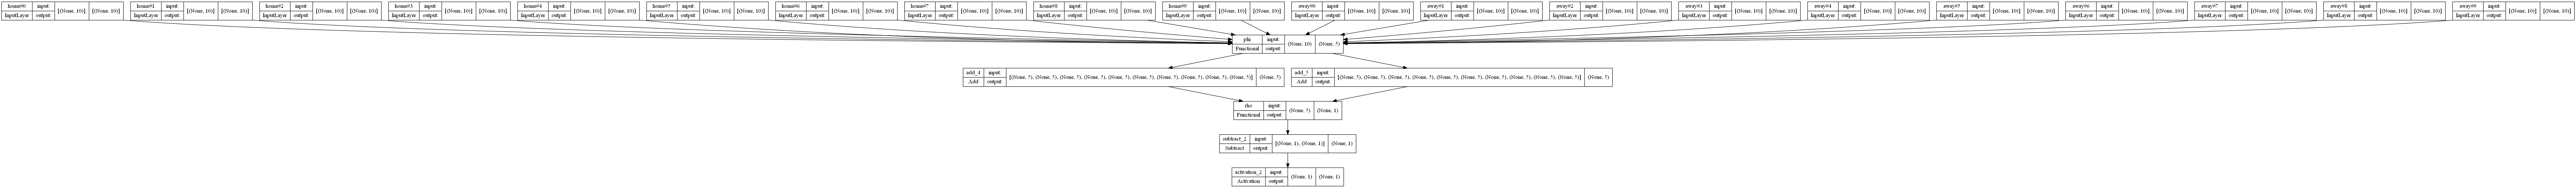

In [35]:
# get feature dim and choose embedding dim
N = len(feature_fields)
M = int(N/2)

# function to spawn a keras implementation of the phi approximator
def spawn_phi():
    inputs = tf.keras.layers.Input(shape=(N), name='phi_in')
    
    x = tf.keras.layers.Dense(N*10, activation='relu')(inputs)
    x = tf.keras.layers.Dense(N*10, activation='relu')(x)
    x = tf.keras.layers.Dense(N*10, activation='relu')(x)
    x = tf.keras.layers.Dense(N*10, activation='relu')(x)
    outputs = tf.keras.layers.Dense(M)(x)
    
    return tf.keras.models.Model(inputs, outputs, name='phi')
    

# function to spawn a keras implementation of the rho approximator
def spawn_rho():
    inputs = tf.keras.layers.Input(shape=(M), name='rho_in')

    x = tf.keras.layers.Dense(M*10, activation='relu')(inputs)
    x = tf.keras.layers.Dense(M*10, activation='relu')(x)
    x = tf.keras.layers.Dense(M*10, activation='relu')(x)
    x = tf.keras.layers.Dense(M*10, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1)(x)

    return tf.keras.models.Model(inputs, outputs, name='rho')

# define the full team comparison model
def spawn_compare_model(phi, rho):
    home_players = [tf.keras.layers.Input(shape=(N), name=('home#%d' % i)) for i in range(NUM_PLAYERS)]
    away_players = [tf.keras.layers.Input(shape=(N), name=('away#%d' % i)) for i in range(NUM_PLAYERS)]

    home_reps = [phi(player) for player in home_players]
    away_reps = [phi(player) for player in away_players]

    home_sum = tf.keras.layers.Add()(home_reps)
    away_sum = tf.keras.layers.Add()(away_reps)

    home_rep = rho(home_sum)
    away_rep = rho(away_sum)

    difference = tf.keras.layers.Subtract()([home_rep, away_rep])
    output = tf.keras.layers.Activation('tanh')(difference)
    return tf.keras.models.Model(inputs=(home_players + away_players), outputs=output)

phi, rho = spawn_phi(), spawn_rho()
model = spawn_compare_model(phi, rho)
tf.keras.utils.plot_model(phi, to_file='phi_plot.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(rho, to_file='rho_plot.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training  Model

In [48]:
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_split=0.1, verbose=2)

Epoch 1/10
151/151 - 7s - loss: 0.9714 - val_loss: 0.9987 - 7s/epoch - 44ms/step
Epoch 2/10
151/151 - 5s - loss: 0.9528 - val_loss: 0.9516 - 5s/epoch - 34ms/step
Epoch 3/10
151/151 - 5s - loss: 0.9493 - val_loss: 0.9682 - 5s/epoch - 34ms/step
Epoch 4/10
151/151 - 5s - loss: 0.9457 - val_loss: 0.9697 - 5s/epoch - 34ms/step
Epoch 5/10
151/151 - 5s - loss: 0.9442 - val_loss: 0.9525 - 5s/epoch - 34ms/step
Epoch 6/10
151/151 - 5s - loss: 0.9438 - val_loss: 0.9510 - 5s/epoch - 34ms/step
Epoch 7/10
151/151 - 5s - loss: 0.9454 - val_loss: 0.9750 - 5s/epoch - 35ms/step
Epoch 8/10
151/151 - 5s - loss: 0.9425 - val_loss: 0.9540 - 5s/epoch - 33ms/step
Epoch 9/10
151/151 - 5s - loss: 0.9430 - val_loss: 0.9664 - 5s/epoch - 32ms/step
Epoch 10/10
151/151 - 5s - loss: 0.9429 - val_loss: 0.9548 - 5s/epoch - 33ms/step


In [54]:
train_pred = model(X_train)
correct = 0
for pred, y in zip(train_pred, Y_train):
    if pred*y == abs(pred): correct += 1

print("%d / %d = %f" % (correct, len(train_pred), correct/len(train_pred)))

test_pred = model(X_test)
correct = 0
for pred, y in zip(test_pred, Y_test):
    if pred*y == abs(pred): correct += 1

print("%d / %d = %f" % (correct, len(test_pred), correct/len(test_pred)))


12918 / 21410 = 0.603363
3131 / 5353 = 0.584906


In [32]:
GAME = 0
home_team, away_team = [], []
for i in range(10):
    home_team.append(phi.predict(X[i][GAME].reshape((-1, N))))
    away_team.append(phi.predict(X[i + 10][GAME].reshape((-1, N))))

home_sum, away_sum = np.sum(home_team, axis=0), np.sum(away_team, axis=0)
home_score, away_score = rho(home_sum), rho(away_sum)

print(home_score.numpy()[0][0], away_score.numpy()[0][0])
print(tf.keras.activations.tanh(home_score.numpy()[0][0] - away_score.numpy()[0][0]).numpy())

Y[GAME]

-0.11342312 0.04408338
-0.1562168


-1